In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess
import sys

In [4]:
fname = 'dMRI_data/ms-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ms-ras.bval' 
bvec_fname = 'dMRI_data/ms-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 99)
b values:  [   0.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700.  700.    0.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
b vectors:  [[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 2.2293058e-01  4.9968055e-01  8.3703119e-01]
 [-1.7871778e-01  4.9333411e-01  8.5128242e-01]
 [-3.7542525e-01  1.4225766e-01  9.1587037e-01]
 [ 4.1157657e-01  7.2193778e-01  5.5624700e-01]
 [ 1.9853516e-01  9.3616748e-01  2.9012811e-01]
 [ 8.4751403e-01  5.2907634e-01  4.2405690e-02]
 [ 7.39

In [5]:
parameters['allow_extrapolation'] = True

In [6]:
#Input volume number
k = 21

#B vector
b = 700
b2000_indcs = np.where(bvals==b)
b0_inds = np.where(bvals==0)
b0_ind = b0_inds[0][0]

In [7]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1) 
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs[bvals==b], k)
print('b sub vectors: ', sub_bvecs)
#print('b sub vector indecs ', sub_indcs)

#def calc_distances(p0, points):
#    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
#def closestPts(pts, K):
#    closest_pts = np.zeros((K, 3))
#    pts_inds = np.zeros(K)
#    #closest_pts[0] = pts[np.random.randint(len(pts))]
#    closest_pts[0] = pts[1]
#    pts_inds[0] = 1
#    distances = calc_distances(closest_pts[0], pts)
#    distances[int(pts_inds[0])] = 1000.0
#    for i in range(1, K):
#        closest_pts[i] = pts[np.argmin(distances)]
#        pts_inds[i] = np.argmin(distances)
#        #distances = np.minimum(distances, calc_distances(closest_pts[i], pts))
#        distances[int(pts_inds[i])] = 1000.0
#    return closest_pts, pts_inds
#sub_bvecs, sub_indcs = closestPts(bvecs[bvals==b], k)
#print('b sub vectors: ', sub_bvecs)

#Choose true indeces
true_sub_indcs = np.zeros(len(sub_indcs))
for i in range(len(sub_indcs)):
    true_sub_indcs[i] = b2000_indcs[0][int(sub_indcs[i])]
true_sub_indcs = np.append(true_sub_indcs, b0_ind)
sorted_true_sub_indcs = np.sort(true_sub_indcs)
#print('b sub vectors: ', sub_bvecs)
print('sorted b sub vector indeces ', sorted_true_sub_indcs)

b sub vectors:  [[-0.17871778  0.49333411  0.85128242]
 [-0.68088585  0.5256443  -0.50999278]
 [ 0.62896943  0.74815804 -0.21132247]
 [ 0.75664991  0.17243032  0.63067305]
 [-0.15568012 -0.20317107  0.96668768]
 [-0.19951271  0.93264794  0.30060336]
 [ 0.83273727  0.20222756 -0.51541471]
 [-0.03439669  0.75075191 -0.65968806]
 [ 0.41157657  0.72193778  0.556247  ]
 [-0.98415816  0.1684573  -0.05526903]
 [-0.71661639  0.50075305  0.48549715]
 [ 0.43850514  0.15385152  0.88546205]
 [-0.37542525  0.14225766  0.91587037]
 [-0.66621846  0.72867197 -0.15871401]
 [ 0.62077832  0.54730117 -0.56133366]
 [ 0.30347744  0.94898587 -0.0855993 ]
 [ 0.22293058  0.49968055  0.83703119]
 [ 0.97062433  0.19699152 -0.13814011]
 [-0.70739847  0.15345097  0.68995672]
 [-0.87868327  0.18046372 -0.44198251]
 [-0.24489762  0.19681381 -0.9493627 ]]
sorted b sub vector indeces  [ 0.  1.  2.  3.  4.  8.  9. 10. 11. 13. 14. 15. 16. 18. 20. 22. 23. 25.
 27. 28. 30. 31.]


In [8]:
sub_indcs

array([ 1., 17.,  9.,  8., 19., 23., 14., 15.,  3., 29., 26.,  7.,  2.,
       21., 12., 10.,  0., 13., 25., 28., 20.])

In [9]:
#Volume Index to predict
#nextIter_sub_bvecs, nextIter_sub_indcs = closestPts(bvecs[bvals==b], k+1)
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs[bvals==b], k+1)
nextIter_true_sub_indcs = np.zeros(len(nextIter_sub_indcs))
for i in range(len(nextIter_sub_indcs)):
    nextIter_true_sub_indcs[i] = b2000_indcs[0][int(nextIter_sub_indcs[i])]
nextIter_true_sub_indcs = np.append(nextIter_true_sub_indcs, b0_ind)
sorted_nextIter_true_sub_indcs = np.sort(nextIter_true_sub_indcs)
print('b sub vector indecs ', sorted_nextIter_true_sub_indcs)
nextIter_sub_indcs = sorted_nextIter_true_sub_indcs.astype(int)
    
inter_sub_indcs = [i for i in sorted_nextIter_true_sub_indcs if i not in sorted_true_sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sorted_true_sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
left_indcs = left_indcs.astype(int)
print("Predicted volume: ", left_indcs)

b sub vector indecs  [ 0.  1.  2.  3.  4.  8.  9. 10. 11. 13. 14. 15. 16. 18. 19. 20. 22. 23.
 25. 27. 28. 30. 31.]
Predicted volume:  19


In [10]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sorted_true_sub_indcs]
print(sub_data.shape)

[  0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700.]
(104, 104, 72, 22)


In [11]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [12]:
#Load registrated data
#nameStr = 'LH_all_voxels/multi_shell_registerered_data/kFrame_correct55.nii.gz'     
#sub_regis_data, sub_regis_affine = load_nifti(nameStr)
#dims_sub = sub_regis_data.shape
#print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
#print('Type: ', sub_regis_data.dtype)

In [13]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

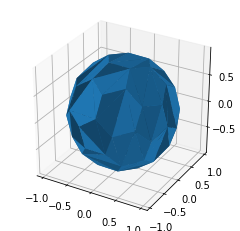

In [14]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

mesh = Mesh('LH/mesh_on_sphere_myself__reg_b700_700_del_fib0_1.xml')
#mesh = Mesh('LH/mesh_on_sphere_myself__reg_b2000_del_fib0_1.xml')
#mesh = Mesh('LH/mesh_on_sphere_myself_b700_2000_del_fib0_1.xml')

plot(mesh)

In [15]:
# Save solution to file in VTK format
vtkfile = File('LH/mesh.pvd')
vtkfile << mesh
mesh.num_vertices()

60

In [16]:
for ind in nextIter_sub_indcs:
    print(ind)

0
1
2
3
4
8
9
10
11
13
14
15
16
18
19
20
22
23
25
27
28
30
31


In [17]:
for ind in sorted_true_sub_indcs:
    print(ind)

0
1
2
3
4
8
9
10
11
13
14
15
16
18
20
22
23
25
27
28
30
31


In [18]:
#len(sorted_true_sub_indcs)

In [19]:
left_indcs

19

In [20]:
sorted_true_sub_indcs

array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 13, 14, 15, 16, 18, 20, 22, 23,
       25, 27, 28, 30, 31])

In [21]:
bvec_volPredict = bvecs[left_indcs]
lh_coefs = np.zeros(len(sorted_true_sub_indcs))

for l in range(len(sorted_true_sub_indcs)):
    if sorted_true_sub_indcs[l] != 0:
        V = FunctionSpace(mesh, "P", 1)
        # get coordinates of DOFs
        dof_coords = V.tabulate_dof_coordinates()
        
        bcs = []
        for ind in sorted_true_sub_indcs:
            if ind!=0:
                if ind==sorted_true_sub_indcs[l]:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    #print('Index: ', ind)
                else:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    
        u = TrialFunction(V) 
        v = TestFunction(V)
        w = Function(V)   
        
        a=inner(grad(u),grad(v))*dx
        
        f = Constant(0.0)
        L = f*v*dx
        solve(a == L, w, bcs)
        
        lh_coefs[l] = w(bvec_volPredict)
        print(lh_coefs[l])
    else:
        lh_coefs[l] = 0
        print(lh_coefs[l])

0.0
0.0
7.786318528560751e-07
0.0
7.91475022103417e-09
0.0
0.0
4.030597931730307e-06
0.0009519945967517242
1.168914169860354e-06
0.0
0.0
0.32511694265925967
0.3560213290698229
1.0570821340105e-06
0.31509747831653584
0.0024157715429568233
0.0003886526023604704
0.0
7.880714737700027e-07
0.0
0.0


In [22]:
lh_coefs

array([0.00000000e+00, 0.00000000e+00, 7.78631853e-07, 0.00000000e+00,
       7.91475022e-09, 0.00000000e+00, 0.00000000e+00, 4.03059793e-06,
       9.51994597e-04, 1.16891417e-06, 0.00000000e+00, 0.00000000e+00,
       3.25116943e-01, 3.56021329e-01, 1.05708213e-06, 3.15097478e-01,
       2.41577154e-03, 3.88652602e-04, 0.00000000e+00, 7.88071474e-07,
       0.00000000e+00, 0.00000000e+00])

In [23]:
np.sum(lh_coefs)

0.9999999999999998

In [24]:
len(lh_coefs)

22

In [25]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))

for i in range(len(sorted_true_sub_indcs)):
    print(i, sorted_true_sub_indcs[i], lh_coefs[i])
    inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*data_float[...,sorted_true_sub_indcs[i]]
inpaintedImg_3D = inpaintedImg_3D/np.sum(lh_coefs)

0 0 0.0
1 1 0.0
2 2 7.786318528560751e-07
3 3 0.0
4 4 7.91475022103417e-09
5 8 0.0
6 9 0.0
7 10 4.030597931730307e-06
8 11 0.0009519945967517242
9 13 1.168914169860354e-06
10 14 0.0
11 15 0.0
12 16 0.32511694265925967
13 18 0.3560213290698229
14 20 1.0570821340105e-06
15 22 0.31509747831653584
16 23 0.0024157715429568233
17 25 0.0003886526023604704
18 27 0.0
19 28 7.880714737700027e-07
20 30 0.0
21 31 0.0


In [26]:
bvec_volPredict

array([-0.36761704,  0.53581387, -0.76010603])

In [27]:
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, "multi_shell/multi_fast_qspace_LH_volume_image_on_sphere_" + str(left_indcs) + "_dely_uncorrected.nii.gz")

In [28]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)